In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
# load 50k real images from Pythia
real_jets = np.load('/home/lukedeo/scratch/data/gan/jetimages.npy', mmap_mode='r')
ix = range(real_jets.shape[0])
np.random.shuffle(ix)
real_jets = np.array(real_jets[ix][:50000])

In [3]:
real_images = real_jets['image']
real_labels = real_jets['signal']

In [4]:
from adversarial_jets import build_generator, build_discriminator, ConstrainedReLU

Using TensorFlow backend.


In [5]:
# g = build_generator(256)
g, (z, image_class), (loc_img, bkg_img) = build_generator(256, return_intermediate=True)

In [6]:
from keras.models import model_from_json, Model
background_model = Model(input=[z, image_class], output=bkg_img)
spiking_model = Model(input=[z, image_class], output=loc_img)

In [7]:
fname = '/home/lukedeo/jet-gan-256.h5'

In [97]:
# fname = sorted(glob('params_generator*'))[-1]

In [98]:
#fname = '/home/lukedeo/great-gan-256.h5'

In [99]:
#from keras.models import model_from_json, Model

In [100]:
#g = model_from_json(open('/home/lukedeo/great-gan-256.json').read(), custom_objects={'ConstrainedReLU': ConstrainedReLU})

In [ ]:
#g.load_weights(fname)

In [8]:
g.load_weights(fname)

In [9]:
# create some random noise and request some specific labels
noise = np.random.normal(0, 1, (50000, 256))
sampled_labels = np.random.randint(0, 2, 50000)

In [10]:
# get a batch to display
generated_images = g.predict(
    [noise, sampled_labels.reshape(-1, 1, 1)], verbose=True, batch_size=128)
generated_images_from_branch0 = background_model.predict(
    [noise, sampled_labels.reshape(-1, 1, 1)], verbose=True, batch_size=128)
generated_images_from_branch1 = spiking_model.predict(
    [noise, sampled_labels.reshape(-1, 1, 1)], verbose=True, batch_size=128)

49792/50000 [============================>.] - ETA: 0s

In [11]:
generated_images = (generated_images) * 100 # because they were previously divided by 100
generated_images_from_branch0 = (generated_images_from_branch0) * 100 # because they were previously divided by 100
generated_images_from_branch1 = (generated_images_from_branch1) * 100 # because they were previously divided by 100

In [12]:
# -- check the quality of the generated images
# -- do they fool the discriminator? (isreal > 0.5?)
# -- we should probably only consider those that do and discard those that don't
b = build_discriminator()
b.load_weights('/home/lukedeo/adversarial-jets/models/separate-clf/params_discriminator_epoch_090.hdf5')
# WHAT'S THE RIGHT SET OF WEIGHTS TO LOAD??

In [16]:
isreal, aux_out = np.array(b.predict(generated_images, verbose=True, batch_size=128))
isreal_pythia, aux_out_pythia = np.array(b.predict(np.expand_dims(real_images, 1), verbose=True, batch_size=128))

50000/50000 [==============================] - 2s     


In [17]:
print '{}% of generated images look real.'.format(100*sum(isreal >= 0.5)[0] / float(len(isreal)))
print '{}% of Pythia images look real.'.format(100*sum(isreal_pythia >= 0.5)[0] / float(len(isreal_pythia)))

3.736% of generated images look real.
18.002% of Pythia images look real.


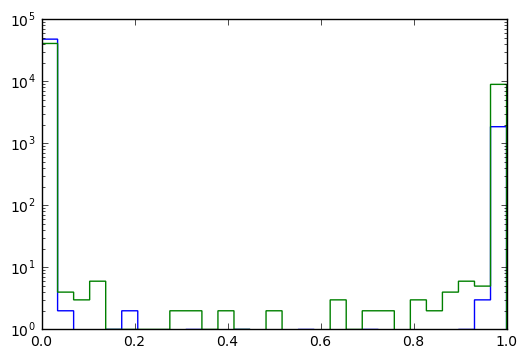

In [18]:
bins = np.linspace(0, 1, 30)
_ = plt.hist(isreal, bins=bins, histtype='step', label='GAN')
_ = plt.hist(isreal_pythia, bins=bins, histtype='step', label='Pythia')
plt.yscale('log')
# note: the D seems to be pretty certain about its predictions (close to 0 and 1) even if they are wrong
# why is it so willing to say that images are fake?
# should we encourage it to predict 'real' more often?

In [19]:
# transform (None, 1, 25, 25) => (None, 25, 25)
generated_images = np.squeeze(generated_images)
generated_images_from_branch0 = np.squeeze(generated_images_from_branch0)
generated_images_from_branch1 = np.squeeze(generated_images_from_branch1)

In [27]:
# save some images out for later analysis
#np.save('/home/micky/scratch/data/gan/gan-images.npy', generated_images)

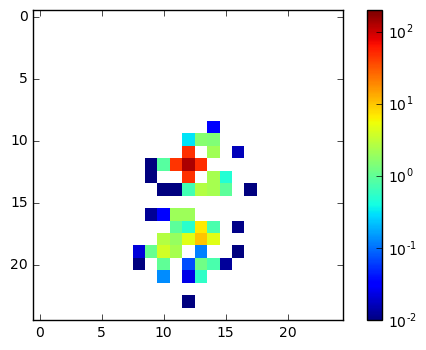

In [20]:
# -- display one single random image (in this case, number 23)
im = real_images[23]
plt.imshow(im, interpolation='nearest', norm=LogNorm(vmin=1e-2, vmax=200))
plt.colorbar()

In [21]:
np.argwhere(isreal.reshape(-1,) > 0.5)

array([[   53],
       [   63],
       [  119],
       ..., 
       [49925],
       [49934],
       [49997]])

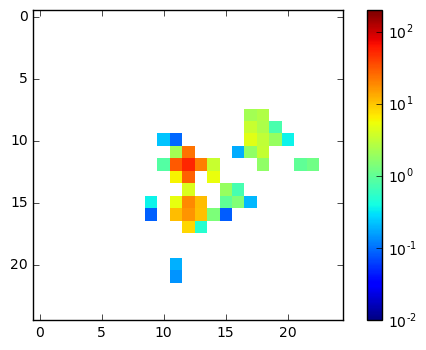

In [22]:
# -- display one single random generated image that was labeled as real
im = generated_images[53]
plt.imshow(im, interpolation='nearest', norm=LogNorm(vmin=1e-2, vmax=200))
plt.colorbar()

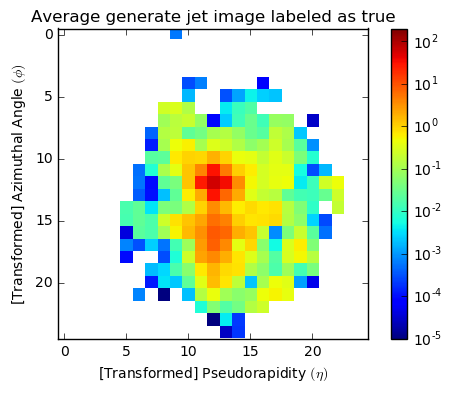

In [23]:
# -- average generated image that fools the D
plt.imshow(generated_images[isreal.reshape(-1,) > 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average generate jet image labeled as true')

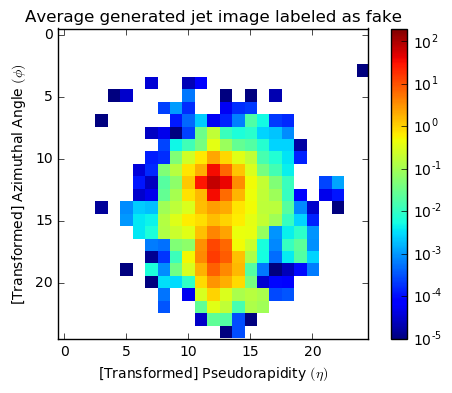

In [24]:
# -- average generated image that does not fool the D
plt.imshow(generated_images[isreal.reshape(-1,) < 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average generated jet image labeled as fake')

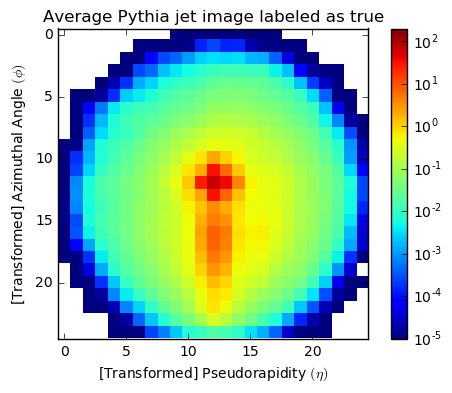

In [25]:
# -- average Pythia image that the D correctly labels as real
plt.imshow(real_images[isreal_pythia.reshape(-1,) > 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average Pythia jet image labeled as true')

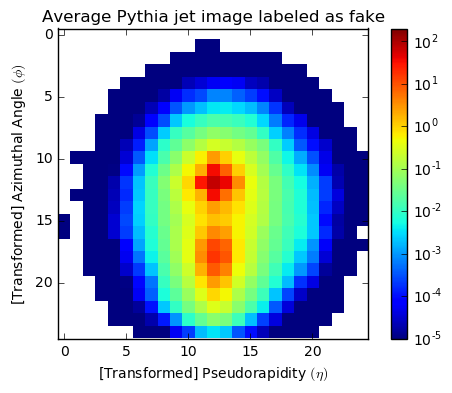

In [26]:
# -- average Pythia image that the D thinks is fake
plt.imshow(real_images[isreal_pythia.reshape(-1,) < 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average Pythia jet image labeled as fake')

## NOTE:
Just by visual inspection, it looks like, on average, images that are more concentrated in the center are more often labelled as fake, while images that are more spread out look more convincingly real.

We can make sense of this by thinking about the fact that the average Pythia image has that nice ring of low energy depositions that expands all the way out to the borders of the image, while the average generate image lacks this property and tends to be more concentrated around the energetic part of the image. Therefore, the Discriminator seems to learn that more spread out images are more likely to be real, and more concentrated images are more likely to be fake.

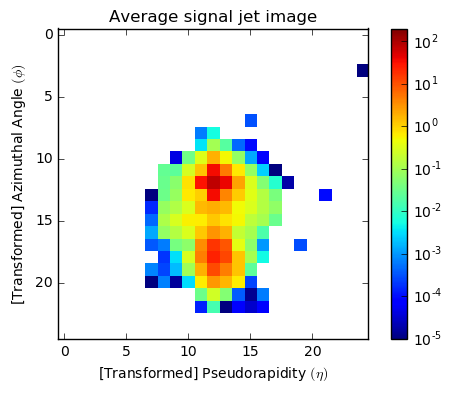

In [27]:
# -- average generated signal image
plt.imshow(generated_images[sampled_labels == 1].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image')

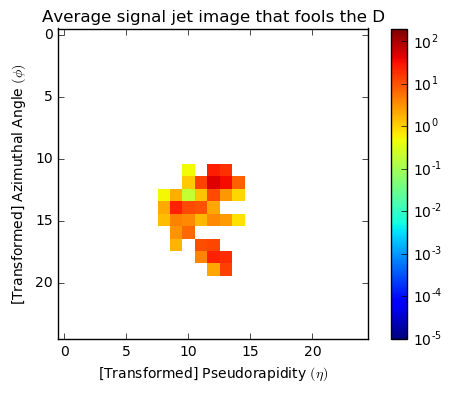

In [28]:
# -- average generated signal image that passes the D
plt.imshow(generated_images[(sampled_labels == 1) & (isreal.reshape(-1,) > 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image that fools the D')

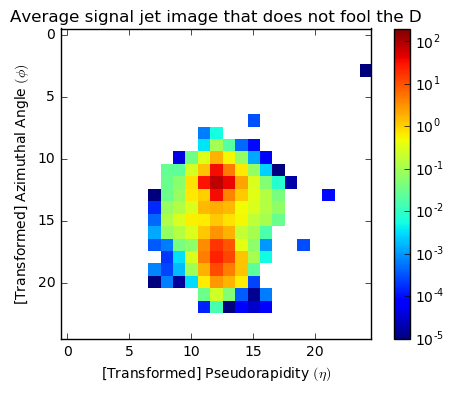

In [29]:
# -- average generated signal image that doesn't pass the D
plt.imshow(generated_images[(sampled_labels == 1) & (isreal.reshape(-1,) < 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image that does not fool the D')

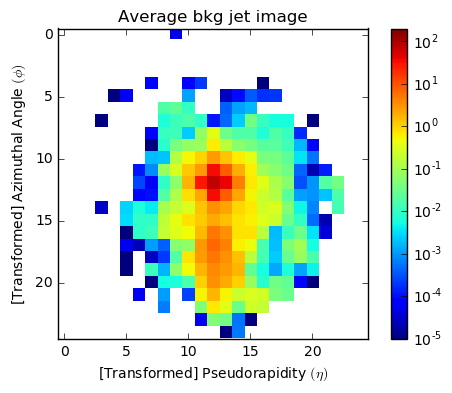

In [30]:
# -- average generated bkg image
plt.imshow(generated_images[sampled_labels == 0].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average bkg jet image')

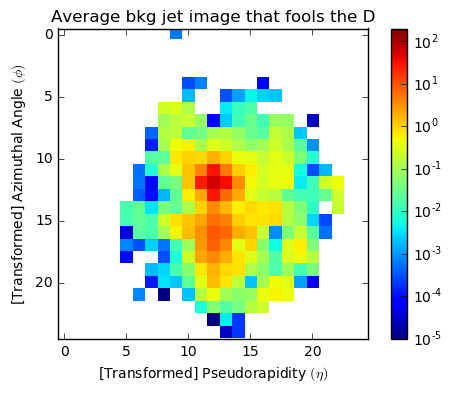

In [31]:
# -- average generated bkg image that fools the D
plt.imshow(generated_images[(sampled_labels == 0) & (isreal.reshape(-1,) > 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average bkg jet image that fools the D')

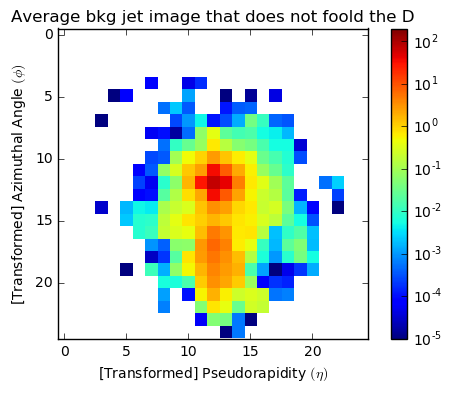

In [32]:
# -- average generated bkg image that doesn't fool the D
plt.imshow(generated_images[(sampled_labels == 0) & (isreal.reshape(-1,) < 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average bkg jet image that does not foold the D')

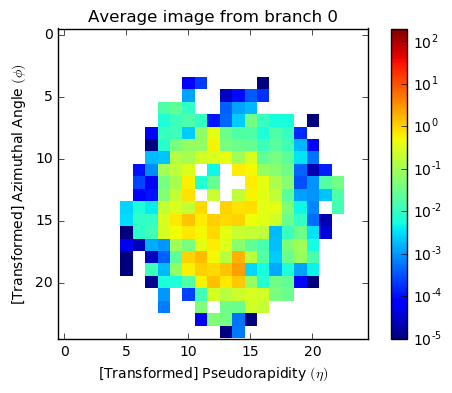

In [33]:
# -- what's being learned by one branch of the G
plt.imshow(generated_images_from_branch0.mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average image from branch 0')

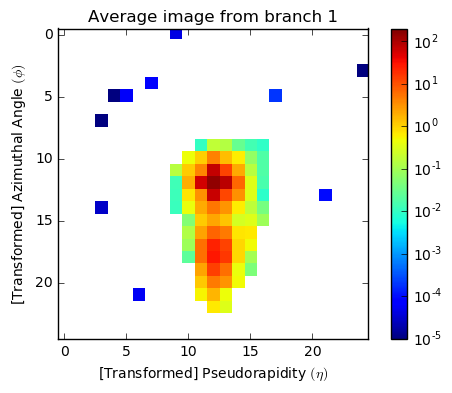

In [34]:
# -- what's being learned by the other branch of the G
plt.imshow(generated_images_from_branch1.mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average image from branch 1')

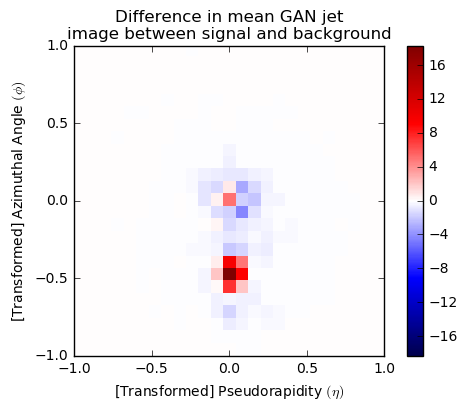

In [35]:
# -- plot difference between mean signal and mean bkg for GAN generated images
diff = generated_images[sampled_labels == 1].mean(axis=0) - generated_images[sampled_labels == 0].mean(axis=0)
lim = np.max(np.abs(diff))
plt.imshow(diff, interpolation='nearest', cmap=cm.seismic, vmax=lim, vmin=-lim, extent=[-1, 1, -1, 1])
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference in mean GAN jet\nimage between signal and background')
plt.colorbar()

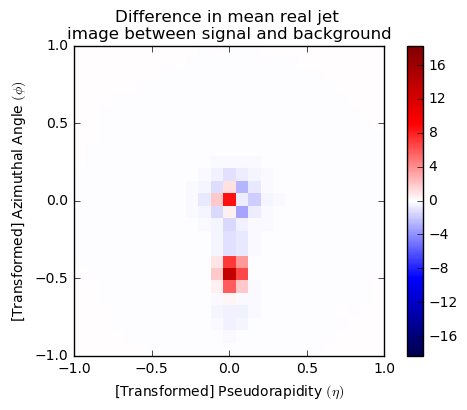

In [36]:
# -- plot difference between mean signal and mean bkg for real images
diff = real_images[real_labels == 1].mean(axis=0) - real_images[real_labels == 0].mean(axis=0)
plt.imshow(diff, interpolation='nearest', cmap=cm.seismic, vmax=lim, vmin=-lim, extent=[-1, 1, -1, 1])
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference in mean real jet \nimage between signal and background')
plt.colorbar()

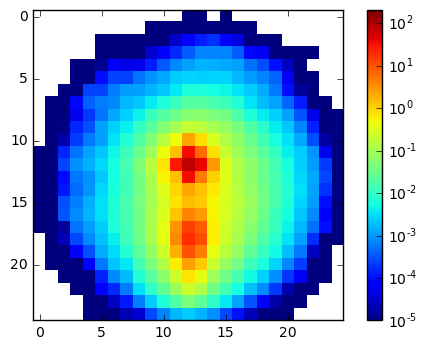

In [37]:
# plot the mean signal jet (real)
plt.imshow(real_images[real_labels == 1].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()

In [38]:
# form the grids you need to represent the eta, phi coordinates
grid = 0.5 * (np.linspace(-1, 1, 26)[:-1] + np.linspace(-1, 1, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

In [39]:
def discrete_mass(jet_image):
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    return np.sqrt(np.square(Px) + np.square(Py))

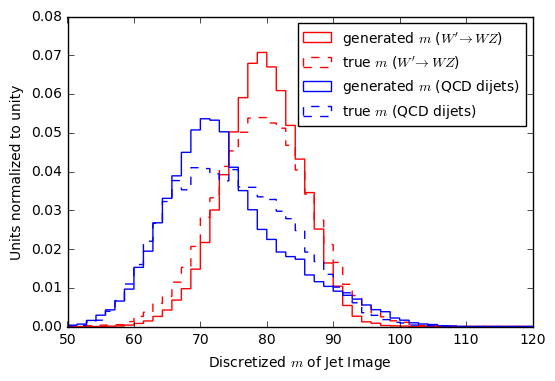

In [40]:
# plot the mass of the GAN vs the Pythia Jets
bins = np.linspace(50, 120, 50)
_ = plt.hist(discrete_mass(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated $m$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_mass(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"true $m$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_mass(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated $m$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_mass(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'true $m$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')

plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(prop={'size':10})
plt.ylim(0, 0.08)
plt.show()

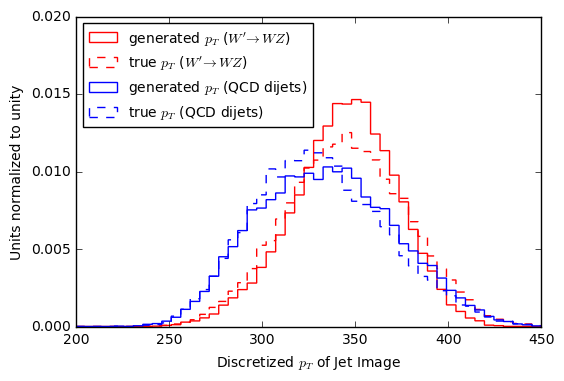

In [41]:
# plot the pT of the GAN vs the Pythia Jets
bins = np.linspace(200, 450, 50)
_ = plt.hist(discrete_pt(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated $p_T$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_pt(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"true $p_T$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_pt(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated $p_T$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_pt(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'true $p_T$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')
plt.xlabel(r'Discretized $p_T$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(loc=2, prop={'size':10})
plt.ylim(0, 0.02)
plt.show()

In [42]:
print real_images.ravel().shape, generated_images.ravel().shape

(31250000,) (31250000,)


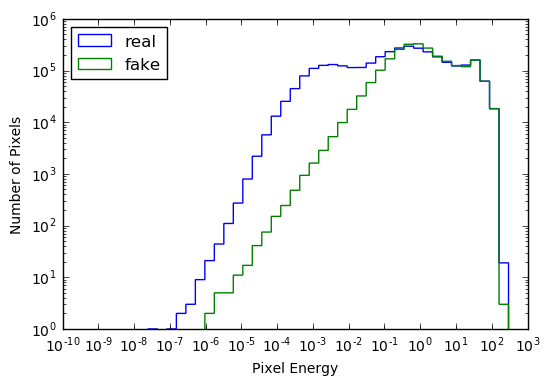

In [43]:
_, bins, _ = plt.hist(real_images.ravel(), 
                      bins=np.logspace(-10, 3, 50), histtype='step', label='real')
#_, bins, _ = plt.hist(real_images.ravel(), 
#            bins=np.linspace(0, 500, 50), log=True, histtype='step', normed=True, label='real')
_ = plt.hist(generated_images.ravel(), 
             bins=bins, histtype='step', label='fake')
plt.xscale('log')
plt.xlabel('Pixel Energy')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper left')

In [ ]:
#np.save('/home/lukedeo/scratch/data/gan/slim.npy', real_jets)

In [46]:
print 'percentage of pixels in the real images that are empty = {}%'.format(
    100 * float((real_images.ravel() == 0).sum()) / len(real_images.ravel())
)

percentage of pixels in the real images that are empty = 89.2976704%


In [47]:
print 'percentage of pixels in the generated images that are empty = {}%'.format(
    100 * float((generated_images.ravel() == 0).sum()) / len(generated_images.ravel())
)

percentage of pixels in the generated images that are empty = 92.282096%


Again, this shows that real images have more active pixels than generated images

# Calculate mass and nsubj

In [50]:
from mass import image_mass_func

In [51]:
jet_mass = image_mass_func(eta, phi, use_keras=False)

In [75]:
jet_mass(np.expand_dims(real_images, 1))

array([ 78.86623897,  80.16181017,  54.82688725, ...,  88.56439669,
        69.68403178,  74.39933881])

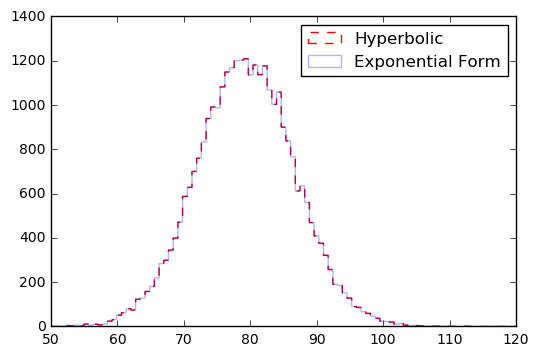

In [76]:
bins = np.linspace(50, 120, 100)
_ = plt.hist(discrete_mass(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label='Hyperbolic', color='red', linestyle='dashed')
_ = plt.hist(jet_mass(np.expand_dims(real_images[real_labels == 1], 1)), 
             bins=bins, histtype='step', label='Exponential Form', alpha=0.3)
plt.legend()
# matches perfectly

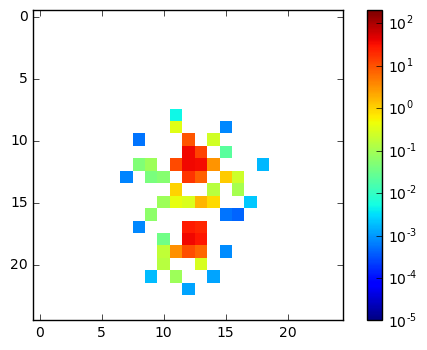

In [77]:
plt.imshow(real_images[0], interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()

In [ ]:
# while (len(proto_jet_eatas) > 2): #should start as the number of pixels, which is hopefully bigger than two :)
#   loop over pairs of pixels
#      find the pair with the smallest value of min(pT1^2,pT2^2)*((eta_1-eta_2)^2+(phi_1-phi_2)^2) #be careful here about delta phi!  i.e. 2\pi-0 is close to zero and not close to 2pi!
#      # ^^ that is not zero? or should I start with all the ones that are zero and remove them?     
#      for this pair, remove their eta, phi, pT from the list and add back (‘winner-takes-all’):
#      eta_add =  pixel_pT_1/cosh(pixel_eta_1) > pixel_pT_2/cosh(pixel_eta_2) ? pixel_eta_1 : pixel_eta_2  #i.e. take the position of the higher energy of the two 
#      phi_add =  pixel_pT_1/cosh(pixel_eta_1) > pixel_pT_2/cosh(pixel_eta_2) ? pixel_phi_1 : pixel_phi_2  #i.e. take the position of the higher energy of the two 
#      proto_jet_eatas+= [ eta_add ]
#      proto_jet_phis += [ phi_add ]
#      proto_jet_pTs += [ (pixel_pT_1/cosh(pixel_eta_1) +  pixel_pT_2/cosh(pixel_eta_2))*cosh(eta_add) ] #energies add and resulting object is massless.

# tau2 = sum over pixels of pT * min { ((proto_jet_eatas[0]-pixel_eta)**2+(proto_jet_phis[o]-pixel_phi)**2)**0.5 , ((proto_jet_eatas[1]-pixel_eta)**2+(proto_jet_phis[1]-pixel_phi)**2)**0.5 }  #be careful here about delta phi!  i.e. 2\pi-0 is close to zero and not close to 2pi!

# return tau1 > 0 ? tau2/tau1 : 0

In [88]:
import math
def dphi(phi1, phi2): 
        return math.acos(math.cos(abs(phi1 - phi2)))

In [92]:
def _tau1(jet_image):
    # -- calculate tau1 
    # find coordinate of most energetic pixel, then use formula to compute tau1
    tau1_axis_eta = phi[np.argmax(jet_image) / 25, 0]
    tau1_axis_phi = eta[0, np.argmax(jet_image) % 25]
    tau1 = np.sum( jet_image * 
            np.sqrt(np.square(tau1_axis_eta - eta) + np.square([dphi(tau1_axis_phi, p) for p in phi.ravel()]).reshape(25, 25))
                 ) 
    return tau1

def _tau2(jet_image):
    # -- calculate tau2
    # do not include empty pixels in the calculation
    proto_jet_etas =  eta[jet_image != 0]
    proto_jet_phis = phi[jet_image != 0]
    proto_jet_pts = jet_image[jet_image != 0]

    # -- iterate until we are left with only 2 pixels
    while (len(proto_jet_etas) > 2):
        # -- form all combinations of indices of cells
        couples = []
        arr = range(len(proto_jet_etas))
        for i in arr:
            couples.extend(zip([arr[i]]*len(arr[i+1:]), arr[i+1:]))

        val = []
        for c in couples:
            val.append(
                min(proto_jet_pts[c[0]]**2, proto_jet_pts[c[1]]**2) * (
                (proto_jet_etas[c[0]] - proto_jet_etas[c[1]])**2 + (dphi(proto_jet_phis[c[0]], proto_jet_phis[c[1]]))**2)
            )
        idx_min = list(couples[np.argmin(val)])
        eta_min = proto_jet_etas[idx_min]
        phi_min = proto_jet_phis[idx_min]
        pt_min = proto_jet_pts[idx_min]

        if pt_min[0]/np.cosh(eta_min[0]) > pt_min[1]/np.cosh(eta_min[1]):
            proto_jet_etas = np.append(proto_jet_etas, eta_min[0])
            proto_jet_phis = np.append(proto_jet_phis, phi_min[0])
        else:
            proto_jet_etas = np.append(proto_jet_etas, eta_min[1])
            proto_jet_phis = np.append(proto_jet_phis, phi_min[0])

        proto_jet_pts = np.append(
                            proto_jet_pts, 
                                  np.cosh(proto_jet_etas[-1]) * (
                                    pt_min[0]/np.cosh(eta_min[0]) +
                                    pt_min[1]/np.cosh(eta_min[1])
                                  )
                            )

        proto_jet_etas = np.delete(proto_jet_etas, idx_min)
        proto_jet_phis = np.delete(proto_jet_phis, idx_min)
        proto_jet_pts = np.delete(proto_jet_pts, idx_min)

    tau2 = np.sum(jet_image * np.array(
        [min(i) for i in zip(
            np.sqrt(np.square(eta.ravel() - proto_jet_etas[0]) + np.square([dphi(p, proto_jet_phis[0]) for p in phi.ravel()])), 
            np.sqrt(np.square(eta.ravel() - proto_jet_etas[1]) + np.square([dphi(p, proto_jet_phis[1]) for p in phi.ravel()]))
         )]
    ).reshape(25,25))
    
    return tau2

def tau21(jet_image):
    tau1 = _tau1(jet_image)
    if tau1 <= 0:
        return 0
    else:
        tau2 = _tau2(jet_image)
        return tau2 / tau1

In [93]:
zip(real_jets['tau_1'][:20], [_tau1(img) for img in real_images[:20]])

[(0.28705782, 78.880135163689033),
 (0.27931508, 188.67494384841947),
 (0.18241169, 52.080180361088146),
 (0.23709503, 76.961077882079877),
 (0.29596585, 162.70356424592143),
 (0.26251778, 86.688494993783522),
 (0.16589347, 58.204931129943212),
 (0.13443747, 42.373046120618817),
 (0.22519778, 62.539130372929158),
 (0.20149623, 60.849493722623123),
 (0.16008504, 53.750141178116223),
 (0.15653567, 54.249055115668142),
 (0.23086779, 86.369569375210475),
 (0.14145859, 41.924308624523263),
 (0.25646737, 67.1920671747841),
 (0.25339457, 65.828962393546732),
 (0.13843925, 38.828982144636285),
 (0.24485181, 64.89764508045495),
 (0.23654163, 70.095279038972649),
 (0.12856466, 48.854319937796951)]

In [95]:
zip(real_jets['tau_2'][:20], [_tau2(img) for img in real_images[:20]])

[(0.060821526, 77.918244893173423),
 (0.063186668, 75.136892679795878),
 (0.13945459, 44.576959858679508),
 (0.03335645, 36.929056975113504),
 (0.056124419, 82.866702053979424),
 (0.033108316, 62.896612341565884),
 (0.033382468, 36.079781371642937),
 (0.054439954, 41.220163057093167),
 (0.026089188, 101.42849280073077),
 (0.052544665, 83.093808549114456),
 (0.03491329, 37.533574971847379),
 (0.040550206, 70.072517788090281),
 (0.10895586, 65.679804039397595),
 (0.068341367, 50.325571870434487),
 (0.068774074, 54.463602111368274),
 (0.08371228, 132.48341947816505),
 (0.091929585, 35.24921196765419),
 (0.11137302, 46.908291598684549),
 (0.092936553, 64.713221955562034),
 (0.043722164, 98.14984879263703)]

In [96]:
zip(real_jets['tau_21'][:20], [tau21(img) for img in real_images[:20]])

[(0.21187901, 0.98780567162417343),
 (0.22622003, 0.39823460999760779),
 (0.76450467, 0.85592944474488242),
 (0.14068811, 0.47984069339174767),
 (0.1896314, 0.50931092037251846),
 (0.12611838, 0.7255474021792192),
 (0.20122835, 0.61987499463051321),
 (0.4049463, 0.97279206549739516),
 (0.11585011, 1.6218404732508938),
 (0.26077244, 1.3655628578914727),
 (0.21809216, 0.69829723511737973),
 (0.25904772, 1.2916818115759592),
 (0.47194052, 0.760450752672721),
 (0.48311925, 1.2003912174474591),
 (0.26815915, 0.81056595519965524),
 (0.33036333, 2.0125399924449137),
 (0.66404277, 0.90780674693846974),
 (0.45485887, 0.7228042179424442),
 (0.39289725, 0.92321798048028003),
 (0.34007919, 2.0090311136784811)]

In [171]:
import tqdm

In [97]:
%%timeit
tau21(real_images[0])

10 loops, best of 3: 98.8 ms per loop


In [214]:
tau21_calculated = [tau21(img) for img in tqdm.tqdm(real_images[:20])]


100%|██████████| 20/20 [00:05<00:00,  4.62it/s]
